In [35]:
"""
A module with functions to load saved networks and train the network for a
given number of epochs. Note that after training is completed, the line

torch.save(network, 'saved_net.pt')

should be run to store the trained network for later use.
"""

import torch
import LSTM_class
import chorales
import matplotlib.pyplot as plt
import numpy as np
import time

def get_network():
    """
    A function which interactively asks the user whether a saved network should be used and
    depending on the answer, will ask for a file name or generate a new network. A default
    filename of saved_net.pt is suggested.
    """
    while True:
        resp = str(input('Should loading of a saved network be attempted? [y\\n]'))
        if resp == 'y':
            # Define the LSTM network by loading a saved version or creating a new one
            name = str(input('Give the filename or press enter for default (saved_net.pt): '))
            if name == '':
                name = 'saved_net.pt'
            try:
                network = torch.load(name)
                network.train()
                print('Loading saved network...')
            except:
                print('Unable to load saved network. Creating new network...')
                network = LSTM_class.LSTM(input_size = 88, output_size = 88)
                network.float()
            break
        elif resp == 'n':
            print('Creating new network...')
            network = LSTM_class.LSTM(input_size = 88, output_size = 88)
            network.float()
            break
        else:
            print('Sorry, that is not a valid option.')

    return network

# Prepare data for input into LSTM network
# Pull from chorales, then convert to torch.tensors of correct shape
def get_chorales_tensors(song):
    '''
    Takes a one-hot encoded song and returns an input tensor and target tensor
    Input: numpy array of shape (88, song_len - 1)
    Output: Two torch tensors of shape (song_len - 1, 1, 88)
    '''
    torch_input = torch.tensor(song[:,:-1],dtype=torch.float).view(song.shape[1] - 1, 1, -1)
    torch_target = torch.tensor(song[:,1:],dtype=torch.float).view(song.shape[1] - 1, 1, -1)

    return torch_input, torch_target

def train(network, loss_fn, optimizer, data, epochs=10):
    # Init Loss vector for plotting
    losses = np.empty(epochs)

    # Start timer
    start = time.time()

    # Train network
    for i in range(epochs):
        for song in data:
            torch_tests, torch_tests_targets = get_chorales_tensors(song)
            network.hidden = network.init_hidden()
            out = network.forward(torch_tests)
            loss = loss_fn(out, torch_tests_targets.view(-1,88))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses[i] = loss.item()

        # Occasionally print the loss
        if i%5 == 0:
            print("Epoch: " + str(i) + "/" + str(epochs) + "; Error: " + str(loss.item()), end='\r')

    end = time.time()
    print('Total Duration: ' + str((end - start)/60) + ' minutes')

    # Plot of loss as a function of epochs
    fig, ax = plt.subplots()
    fig.suptitle('Loss Function: ' + str(loss_fn))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.plot(losses)
    plt.show(block = False)


Should loading of a saved network be attempted? [y\n]n
Creating new network...
Total Duration: 0.8910301049550374 minutes


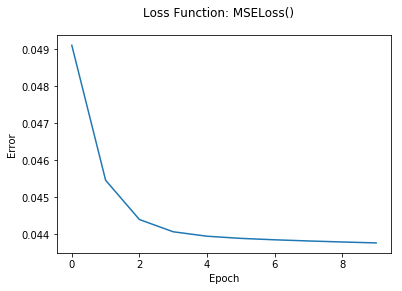

In [36]:
# Define the network
network = get_network()

# Define the loss function and optimization function
loss_library = {
'MSELoss': torch.nn.MSELoss(),
'L1Loss': torch.nn.L1Loss(),
'CrossEntropyLoss': torch.nn.CrossEntropyLoss(),
'NLLLoss': torch.nn.NLLLoss()
}

loss_fn = loss_library['MSELoss'] # Pick loss function by editing key
optimizer = torch.optim.SGD(network.parameters(), lr=0.05, momentum=0.5)

# Define the training and validation data
training_data = chorales.train
validation_data = chorales.valid

train(network, loss_fn, optimizer, training_data, epochs=10)

# Save the network for reuse
torch.save(network, 'saved_net.pt')